# Imports

In [1]:
import os
import random
from datetime import datetime

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import numpy as np
import torch
from transformers import T5Tokenizer

from evaluation import Evaluator
from visualization import plot_graphs
from data_utils.dataset import prepare_data
from data_utils.utils import read_json
from models.rec_ace import RecACEWrapModel, detokenize_and_clean

c:\Users\SharonK\.virtualenvs\DS38-Dev\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.1.0)/charset_normalizer (2.0.7) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


## Seeds

In [2]:
SEED = 42

# Set the random seed for Python
random.seed(SEED)

# Set the random seed for numpy
np.random.seed(SEED)

torch.manual_seed(SEED)

# Data Paths

In [3]:
datasets_dict = {
    # Default
    'Default Train Clean': 'data/default/train_clean.json',
    'Default Train Other': 'data/default/train_other.json',
    'Default Dev Clean': 'data/default/dev_clean.json',
    'Default Dev Other': 'data/default/dev_other.json',
    # Video
    'Video Train Clean': 'data/video/train_clean.json',
    'Video Train Other': 'data/video/train_other.json',
    'Video Dev Clean': 'data/video/dev_clean.json',
    'Video Dev Other': 'data/video/dev_other.json'
}

# Load essentials

In [4]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [5]:
debug = False

# Base architecture
t5_type = 't5-small'

# How to quantize the confidence vectors [only required for rec_ac]
bin_size=10

results_dir = './results'

### Tokenizer

In [6]:
tokenizer = T5Tokenizer.from_pretrained("t5-small")

## Read Data

In [7]:
# Clean data
train_set = read_json(json_path=datasets_dict['Default Train Clean'])
dev_set = read_json(json_path=datasets_dict['Default Dev Clean'])

# Other data
train_set_other = read_json(json_path=datasets_dict['Default Train Other'])
dev_set_other = read_json(json_path=datasets_dict['Default Dev Other'])

## Prepare as DataLoader

In [8]:
batch_size = 64

# Clean data
train_loader = prepare_data(data=train_set, tokenizer=tokenizer, batch_size=batch_size, shuffle=True, debug=debug)
dev_loader = prepare_data(data=dev_set, tokenizer=tokenizer, batch_size=batch_size, shuffle=False)

# Other data
train_loader_other = prepare_data(data=train_set_other, tokenizer=tokenizer, batch_size=batch_size, shuffle=True, debug=debug)
dev_loader_other = prepare_data(data=dev_set_other, tokenizer=tokenizer, batch_size=batch_size, shuffle=False)

- Converting the input sentences into tokens
- Converting the GT sentences into tokens
- Converting the input sentences into tokens
- Converting the GT sentences into tokens
- Converting the input sentences into tokens
- Converting the GT sentences into tokens
- Converting the input sentences into tokens
- Converting the GT sentences into tokens


# Evaluating metrics for the ASR (for train and dev sets)
This is useful for the convergence plots

In [10]:
asr_evaluators = {}

for data_type in ['Clean', 'Other']:

    # Print data type header
    print(f'Running ASR evaluation on {data_type} datasets')

    types = ['train', 'dev']
    asr_evaluator = Evaluator(metrics=['wer', 'em', 'bleu', 'gleu'], set_types=types)

    data_loaders = [train_loader, dev_loader] if data_type == 'Clean' else [train_loader_other, dev_loader_other]
    for set_type, loader in zip(types, data_loaders):
        for batch in loader:
            reference = detokenize_and_clean(tokenizer, batch['sentences'])
            predicted = detokenize_and_clean(tokenizer, batch['labels'])
            asr_evaluator.calculate_metrics(set_type=set_type, reference=reference, predicted=predicted)

    asr_evaluator.end_epoch_routine(print_metrics=False)

    # Print final metrics
    asr_evaluator.print_final_metrics()

    # Save results to disk
    dir_path = os.path.join(results_dir, 'ASR', data_type)
    os.makedirs(dir_path, exist_ok=True)
    asr_evaluator.store_df(dir_path)

    # Save evaluator for later use
    asr_evaluators[data_type] = asr_evaluator

    print()

Running ASR evaluation on Clean datasets
Train Metrics:
+----+-------+-------+--------+--------+
|    |   wer |    em |   bleu |   gleu |
|----+-------+-------+--------+--------|
|  1 | 0.126 | 0.104 |  0.772 |  0.785 |
+----+-------+-------+--------+--------+

Dev Metrics:
+----+-------+-------+--------+--------+
|    |   wer |    em |   bleu |   gleu |
|----+-------+-------+--------+--------|
|  1 | 0.132 | 0.307 |  0.754 |  0.795 |
+----+-------+-------+--------+--------+


Running ASR evaluation on Other datasets
Train Metrics:
+----+-------+-------+--------+--------+
|    |   wer |    em |   bleu |   gleu |
|----+-------+-------+--------+--------|
|  1 | 0.229 | 0.056 |  0.644 |  0.668 |
+----+-------+-------+--------+--------+

Dev Metrics:
+----+-------+-------+--------+--------+
|    |   wer |    em |   bleu |   gleu |
|----+-------+-------+--------+--------|
|  1 | 0.293 | 0.132 |  0.557 |  0.614 |
+----+-------+-------+--------+--------+




# Training

In [22]:
def training(model, n_epochs, train_data, dev_data, optimizer, exp_name, save_model=True):
    """ Training loop for the model

        Args:
            model (nn.Module): Model to train
            n_epochs (int): Number of epochs to train
            train_data (DataLoader): DataLoader with train data
            dev_data (DataLoader): DataLoader with dev data
            optimizer (torch.optim): Optimizer for the model
            exp_name (str): Name of the experiment
            save_model (bool): Whether to save the model after training

        Returns:
            dict: Dictionary with train and dev losses and accuracies
    """

    assert exp_name, "Must supply experiment name"
    assert model.model_type in ['original', 'rec_ace'], f"{model.model_type} is not a valid training scheme"

    print(f"Experiment name: {exp_name}")
    print(f"Training model of type: {model.model_type}")
    print(f"Confidence vectors are {'NOT IN USED' if model.model_type == 'original' else 'IN USED'}")

    if save_model:
        timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        output_dir = os.path.join(results_dir, f'{exp_name}/{timestamp}')
        os.makedirs(output_dir, exist_ok=True)
        print(f"Saving model to: {output_dir}")

    # Initialize metrics evaluator
    evaluator = Evaluator(metrics=['wer', 'em'], set_types=['train', 'dev'])
    train_epoch_losses, dev_epoch_losses = [], []

    # Training loop
    pbar = tqdm(range(n_epochs), position=0, leave=False)
    for epoch in pbar:
        pbar.set_description(f"Epoch: {epoch+1}/{n_epochs}")

        train_losses, dev_losses = [], []

        ### TRAIN
        model.train()

        # Iterating over batches in train data
        pbar_train = tqdm(train_data, desc="Train", leave=False)
        for batch in pbar_train:

            optimizer.zero_grad()

            X = batch['sentences'].to(DEVICE)
            S = batch['scores'].to(DEVICE)
            y = batch['labels'].to(DEVICE)

            preds = model(input_ids=X, labels=y, scores_ids=S)

            loss = preds.loss
            logits = preds.logits

            reference = detokenize_and_clean(tokenizer, y)
            predicted = detokenize_and_clean(tokenizer, logits.argmax(dim=-1))

            train_losses.append(loss.item())
            evaluator.calculate_metrics(set_type='train', reference=reference, predicted=predicted)

            loss.backward()
            optimizer.step()

        ### Evaluate DEV set
        model.eval()

        # No need for gradients when evaluating
        with torch.no_grad():
            pbar_dev = tqdm(dev_data, desc="Dev", leave=False)
            for batch in pbar_dev:

                X = batch['sentences'].to(DEVICE)
                S = batch['scores'].to(DEVICE)
                y = batch['labels'].to(DEVICE)

                dev_preds = model(input_ids=X, labels=y, scores_ids=S)

                dev_loss = dev_preds.loss
                dev_logits = dev_preds.logits

                def_reference = detokenize_and_clean(tokenizer, y)
                def_predicted = detokenize_and_clean(tokenizer, dev_logits.argmax(dim=-1))
                
                dev_losses.append(dev_loss.item())
                evaluator.calculate_metrics(set_type='dev', reference=def_reference, predicted=def_predicted)

        # End of epoch
        print(f"\tDone Epoch: {epoch+1}/{n_epochs}")
        train_epoch_losses.append(np.mean(train_losses))
        dev_epoch_losses.append(np.mean(dev_losses))
        print(f"\t\tLoss\t|\tTrain AVG: {train_epoch_losses[-1]:.04}, Dev AVG: {dev_epoch_losses[-1]:.04}")      
        evaluator.end_epoch_routine(print_metrics=True, indent=2)

        if save_model:
            model.save_to_disk(output_dir + f"/epoch_{epoch+1}.pt")

        if os.path.exists(output_dir + '/.stop'):
            print("Stopping training")
            break
    
    losses = {'train': train_epoch_losses, 'dev': dev_epoch_losses}

    if save_model:
        evaluator.store_df(output_dir, losses=losses)

    print()
    print("Training finished!")
    print()

    return model, evaluator.get_merged_df(losses)

# Experiments
Training the following models:
1. Rec-ACE: T5 with confidence training on 'Clean' dataset
1. Original: T5 training on 'Clean' dataset
1. Rec-ACE(trained on other): T5 with confidence training on 'Other' dataset
1. Original(trained on other): T5 training on 'Other' dataset
1. P-Rec-ACE: T5 with confidence training on Prompt-Engineered 'Clean' dataset
1. P-Original: T5 training on Prompt-Engineered 'Clean' dataset

## Model Debug

#### Training

In [12]:
if debug:
    model_debug = RecACEWrapModel(t5_type=t5_type, model_type='rec_ace', bin_size=bin_size, use_pretrained=True)
    model_debug.to(DEVICE)

    optimizer = torch.optim.Adam(model_debug.parameters(), lr=1e-4)

    model_debug, debub_metrics_df = training(
        model=model_debug,
        n_epochs=3,
        train_data=train_loader,
        dev_data=dev_loader,
        optimizer=optimizer,
        exp_name=f"DebugRecAce_Clean",
        save_model=True)

#### Analysis

In [13]:
if debug:
    plot_graphs(debub_metrics_df, gt_df=asr_evaluators['Clean'].metrics_df, fig_size=(20,8))

## Model REC-ACE

#### Training

In [14]:
assert debug==False, "You are in debug mode, please change to False"

rec_ace_model = RecACEWrapModel(t5_type=t5_type, model_type='rec_ace', bin_size=bin_size, use_pretrained=True).to(DEVICE)
rec_ace_optimizer = torch.optim.Adam(rec_ace_model.parameters(), lr=1e-4)

rec_ace_model, rec_ace_metrics_df = training(
    model=rec_ace_model,
    n_epochs=50,
    train_data=train_loader,
    dev_data=dev_loader,
    optimizer=rec_ace_optimizer,
    exp_name=f"rec_ace_Clean",
    save_model=True)

Experiment name: rec_ace_Clean
Training model of type: rec_ace
Confidence vectors are IN USED
Saving model to: ./results\rec_ace_Clean/2023-08-23_01-46-03


  0%|          | 0/50 [00:00<?, ?it/s]

Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 1/50
		Loss	|	Train AVG: 0.3542, Dev AVG: 0.2313
		Metrics	|	Train: wer=0.1482, em=0.08711 ; Dev: wer=0.2218, em=0.2028


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 2/50
		Loss	|	Train AVG: 0.2783, Dev AVG: 0.3547
		Metrics	|	Train: wer=0.1249, em=0.1102 ; Dev: wer=0.4012, em=0.1014


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 3/50
		Loss	|	Train AVG: 0.2563, Dev AVG: 0.6683
		Metrics	|	Train: wer=0.1188, em=0.1179 ; Dev: wer=0.3274, em=0.2406


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 4/50
		Loss	|	Train AVG: 0.2401, Dev AVG: 0.9221
		Metrics	|	Train: wer=0.1144, em=0.1235 ; Dev: wer=0.556, em=0.1094


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 5/50
		Loss	|	Train AVG: 0.2282, Dev AVG: 0.2339
		Metrics	|	Train: wer=0.111, em=0.1292 ; Dev: wer=0.2866, em=0.2261


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 6/50
		Loss	|	Train AVG: 0.2184, Dev AVG: 0.1436
		Metrics	|	Train: wer=0.1084, em=0.1339 ; Dev: wer=0.1647, em=0.3085


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 7/50
		Loss	|	Train AVG: 0.2107, Dev AVG: 0.3227
		Metrics	|	Train: wer=0.1059, em=0.1375 ; Dev: wer=0.4391, em=0.1177


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 8/50
		Loss	|	Train AVG: 0.2039, Dev AVG: 0.1278
		Metrics	|	Train: wer=0.1041, em=0.1407 ; Dev: wer=0.1764, em=0.3075


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 9/50
		Loss	|	Train AVG: 0.1982, Dev AVG: 0.2229
		Metrics	|	Train: wer=0.1026, em=0.144 ; Dev: wer=0.3162, em=0.2078


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 10/50
		Loss	|	Train AVG: 0.1928, Dev AVG: 0.1003
		Metrics	|	Train: wer=0.1007, em=0.1468 ; Dev: wer=0.1194, em=0.3507


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 11/50
		Loss	|	Train AVG: 0.1879, Dev AVG: 0.1818
		Metrics	|	Train: wer=0.09938, em=0.1496 ; Dev: wer=0.2128, em=0.2566


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 12/50
		Loss	|	Train AVG: 0.1836, Dev AVG: 0.1776
		Metrics	|	Train: wer=0.09818, em=0.1521 ; Dev: wer=0.2375, em=0.2409


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 13/50
		Loss	|	Train AVG: 0.1796, Dev AVG: 0.1214
		Metrics	|	Train: wer=0.09692, em=0.1548 ; Dev: wer=0.1592, em=0.3165


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 14/50
		Loss	|	Train AVG: 0.176, Dev AVG: 0.1324
		Metrics	|	Train: wer=0.0958, em=0.1567 ; Dev: wer=0.1608, em=0.3096


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 15/50
		Loss	|	Train AVG: 0.1726, Dev AVG: 0.2527
		Metrics	|	Train: wer=0.0947, em=0.1576 ; Dev: wer=0.3544, em=0.1581


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 16/50
		Loss	|	Train AVG: 0.1692, Dev AVG: 0.1788
		Metrics	|	Train: wer=0.0938, em=0.161 ; Dev: wer=0.2324, em=0.2485


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 17/50
		Loss	|	Train AVG: 0.1661, Dev AVG: 0.1712
		Metrics	|	Train: wer=0.0927, em=0.1632 ; Dev: wer=0.2362, em=0.2485


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 18/50
		Loss	|	Train AVG: 0.1633, Dev AVG: 0.1394
		Metrics	|	Train: wer=0.09189, em=0.166 ; Dev: wer=0.1941, em=0.286


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 19/50
		Loss	|	Train AVG: 0.1607, Dev AVG: 0.1248
		Metrics	|	Train: wer=0.09099, em=0.1674 ; Dev: wer=0.171, em=0.2947


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 20/50
		Loss	|	Train AVG: 0.158, Dev AVG: 0.1258
		Metrics	|	Train: wer=0.09007, em=0.1696 ; Dev: wer=0.1718, em=0.2987


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 21/50
		Loss	|	Train AVG: 0.1554, Dev AVG: 0.09066
		Metrics	|	Train: wer=0.08928, em=0.1707 ; Dev: wer=0.1075, em=0.3736


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 22/50
		Loss	|	Train AVG: 0.153, Dev AVG: 0.1386
		Metrics	|	Train: wer=0.08863, em=0.1731 ; Dev: wer=0.2041, em=0.2754


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 23/50
		Loss	|	Train AVG: 0.1506, Dev AVG: 0.1928
		Metrics	|	Train: wer=0.08777, em=0.1749 ; Dev: wer=0.2658, em=0.2188


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 24/50
		Loss	|	Train AVG: 0.1485, Dev AVG: 0.3695
		Metrics	|	Train: wer=0.08701, em=0.177 ; Dev: wer=0.4544, em=0.09411


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 25/50
		Loss	|	Train AVG: 0.1463, Dev AVG: 0.1791
		Metrics	|	Train: wer=0.08642, em=0.1788 ; Dev: wer=0.2701, em=0.2249


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 26/50
		Loss	|	Train AVG: 0.1441, Dev AVG: 0.2025
		Metrics	|	Train: wer=0.08556, em=0.1812 ; Dev: wer=0.2915, em=0.2028


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 27/50
		Loss	|	Train AVG: 0.1421, Dev AVG: 0.1056
		Metrics	|	Train: wer=0.08506, em=0.1837 ; Dev: wer=0.1455, em=0.3303


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 28/50
		Loss	|	Train AVG: 0.1403, Dev AVG: 0.1418
		Metrics	|	Train: wer=0.08447, em=0.1845 ; Dev: wer=0.2102, em=0.2602


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 29/50
		Loss	|	Train AVG: 0.1382, Dev AVG: 0.2369
		Metrics	|	Train: wer=0.08364, em=0.1852 ; Dev: wer=0.335, em=0.1697


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 30/50
		Loss	|	Train AVG: 0.1366, Dev AVG: 0.1013
		Metrics	|	Train: wer=0.08312, em=0.1874 ; Dev: wer=0.1372, em=0.3434


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 31/50
		Loss	|	Train AVG: 0.1347, Dev AVG: 0.1248
		Metrics	|	Train: wer=0.0824, em=0.1896 ; Dev: wer=0.187, em=0.29


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 32/50
		Loss	|	Train AVG: 0.1331, Dev AVG: 0.133
		Metrics	|	Train: wer=0.08201, em=0.1913 ; Dev: wer=0.2008, em=0.2743


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 33/50
		Loss	|	Train AVG: 0.1312, Dev AVG: 0.1541
		Metrics	|	Train: wer=0.08124, em=0.1925 ; Dev: wer=0.2467, em=0.2489


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 34/50
		Loss	|	Train AVG: 0.1296, Dev AVG: 0.1711
		Metrics	|	Train: wer=0.08067, em=0.1936 ; Dev: wer=0.264, em=0.2278


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 35/50
		Loss	|	Train AVG: 0.1279, Dev AVG: 0.1217
		Metrics	|	Train: wer=0.07998, em=0.1962 ; Dev: wer=0.1846, em=0.2936


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 36/50
		Loss	|	Train AVG: 0.1264, Dev AVG: 0.142
		Metrics	|	Train: wer=0.07952, em=0.1978 ; Dev: wer=0.22, em=0.2638


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 37/50
		Loss	|	Train AVG: 0.1249, Dev AVG: 0.1587
		Metrics	|	Train: wer=0.07909, em=0.1991 ; Dev: wer=0.2335, em=0.2522


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 38/50
		Loss	|	Train AVG: 0.1235, Dev AVG: 0.1706
		Metrics	|	Train: wer=0.07869, em=0.2002 ; Dev: wer=0.2589, em=0.2355


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 39/50
		Loss	|	Train AVG: 0.122, Dev AVG: 0.1036
		Metrics	|	Train: wer=0.07809, em=0.2031 ; Dev: wer=0.1481, em=0.3299


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 40/50
		Loss	|	Train AVG: 0.1205, Dev AVG: 0.129
		Metrics	|	Train: wer=0.07747, em=0.2042 ; Dev: wer=0.1904, em=0.2834


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 41/50
		Loss	|	Train AVG: 0.1192, Dev AVG: 0.1197
		Metrics	|	Train: wer=0.07701, em=0.2063 ; Dev: wer=0.1749, em=0.2951


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 42/50
		Loss	|	Train AVG: 0.1176, Dev AVG: 0.1178
		Metrics	|	Train: wer=0.07647, em=0.2082 ; Dev: wer=0.1783, em=0.3012


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 43/50
		Loss	|	Train AVG: 0.1165, Dev AVG: 0.1215
		Metrics	|	Train: wer=0.07586, em=0.2102 ; Dev: wer=0.1835, em=0.2896


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 44/50
		Loss	|	Train AVG: 0.1152, Dev AVG: 0.1211
		Metrics	|	Train: wer=0.07542, em=0.2103 ; Dev: wer=0.1828, em=0.2925


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 45/50
		Loss	|	Train AVG: 0.114, Dev AVG: 0.1464
		Metrics	|	Train: wer=0.075, em=0.2141 ; Dev: wer=0.2152, em=0.27


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 46/50
		Loss	|	Train AVG: 0.1126, Dev AVG: 0.1534
		Metrics	|	Train: wer=0.0744, em=0.2143 ; Dev: wer=0.2265, em=0.2464


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 47/50
		Loss	|	Train AVG: 0.1114, Dev AVG: 0.1188
		Metrics	|	Train: wer=0.07397, em=0.2167 ; Dev: wer=0.1696, em=0.2983


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 48/50
		Loss	|	Train AVG: 0.1102, Dev AVG: 0.09688
		Metrics	|	Train: wer=0.07362, em=0.2164 ; Dev: wer=0.1231, em=0.3528


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 49/50
		Loss	|	Train AVG: 0.1091, Dev AVG: 0.1169
		Metrics	|	Train: wer=0.07309, em=0.2179 ; Dev: wer=0.1675, em=0.2932


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 50/50
		Loss	|	Train AVG: 0.1077, Dev AVG: 0.1069
		Metrics	|	Train: wer=0.07265, em=0.2191 ; Dev: wer=0.14, em=0.3267

Training finished!



#### Anaylsis

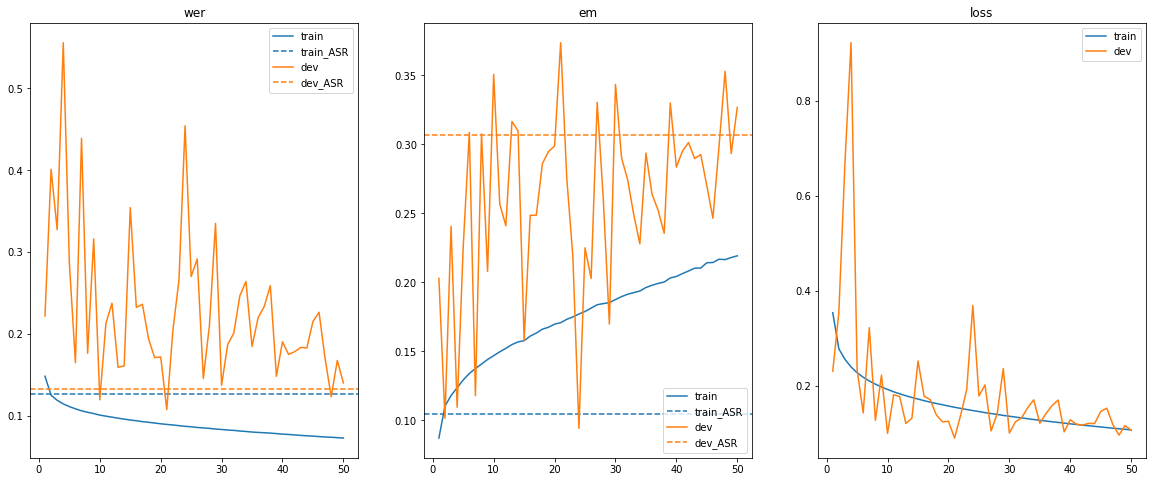

In [15]:
plot_graphs(rec_ace_metrics_df, gt_df=asr_evaluators['Clean'].metrics_df, fig_size=(20,8))

## Model Original T5

#### Training

In [16]:
assert debug==False, "You are in debug mode, please change to False"

orig_model = RecACEWrapModel(t5_type=t5_type, model_type='original', bin_size=bin_size, use_pretrained=True).to(DEVICE)
orig_optimizer = torch.optim.Adam(orig_model.parameters(), lr=1e-4)

orig_model, orig_metrics_df = training(
    model=orig_model,
    n_epochs=50,
    train_data=train_loader,
    dev_data=dev_loader,
    optimizer=orig_optimizer,
    exp_name=f"original_f5_Clean",
    save_model=True)

Experiment name: original_f5_Clean
Training model of type: original
Confidence vectors are NOT IN USED
Saving model to: ./results\original_f5_Clean/2023-08-23_13-31-43


  0%|          | 0/50 [00:00<?, ?it/s]

Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 1/50
		Loss	|	Train AVG: 0.3514, Dev AVG: 0.2299
		Metrics	|	Train: wer=0.1468, em=0.08647 ; Dev: wer=0.216, em=0.197


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 2/50
		Loss	|	Train AVG: 0.278, Dev AVG: 0.1922
		Metrics	|	Train: wer=0.1248, em=0.111 ; Dev: wer=0.2138, em=0.2355


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 3/50
		Loss	|	Train AVG: 0.257, Dev AVG: 0.1705
		Metrics	|	Train: wer=0.1186, em=0.1174 ; Dev: wer=0.1631, em=0.2806


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 4/50
		Loss	|	Train AVG: 0.2428, Dev AVG: 0.1825
		Metrics	|	Train: wer=0.1147, em=0.1227 ; Dev: wer=0.2073, em=0.2478


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 5/50
		Loss	|	Train AVG: 0.232, Dev AVG: 0.3221
		Metrics	|	Train: wer=0.1118, em=0.1272 ; Dev: wer=0.4199, em=0.1145


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 6/50
		Loss	|	Train AVG: 0.223, Dev AVG: 0.207
		Metrics	|	Train: wer=0.1091, em=0.131 ; Dev: wer=0.2661, em=0.2086


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 7/50
		Loss	|	Train AVG: 0.2155, Dev AVG: 0.1896
		Metrics	|	Train: wer=0.1069, em=0.1355 ; Dev: wer=0.2319, em=0.2293


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 8/50
		Loss	|	Train AVG: 0.2092, Dev AVG: 0.3311
		Metrics	|	Train: wer=0.1052, em=0.1379 ; Dev: wer=0.4274, em=0.1068


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 9/50
		Loss	|	Train AVG: 0.2034, Dev AVG: 0.1519
		Metrics	|	Train: wer=0.1036, em=0.1399 ; Dev: wer=0.1783, em=0.2755


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 10/50
		Loss	|	Train AVG: 0.1983, Dev AVG: 0.3682
		Metrics	|	Train: wer=0.1021, em=0.1437 ; Dev: wer=0.4427, em=0.08721


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 11/50
		Loss	|	Train AVG: 0.1935, Dev AVG: 0.4464
		Metrics	|	Train: wer=0.1009, em=0.1455 ; Dev: wer=0.4745, em=0.07013


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 12/50
		Loss	|	Train AVG: 0.1893, Dev AVG: 0.3846
		Metrics	|	Train: wer=0.09962, em=0.1467 ; Dev: wer=0.4495, em=0.08721


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 13/50
		Loss	|	Train AVG: 0.1853, Dev AVG: 0.5713
		Metrics	|	Train: wer=0.09814, em=0.1502 ; Dev: wer=0.5738, em=0.04397


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 14/50
		Loss	|	Train AVG: 0.1818, Dev AVG: 0.5574
		Metrics	|	Train: wer=0.09745, em=0.1514 ; Dev: wer=0.5656, em=0.03815


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 15/50
		Loss	|	Train AVG: 0.1782, Dev AVG: 0.2976
		Metrics	|	Train: wer=0.09646, em=0.1537 ; Dev: wer=0.3941, em=0.1185


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 16/50
		Loss	|	Train AVG: 0.1749, Dev AVG: 0.4671
		Metrics	|	Train: wer=0.09533, em=0.1562 ; Dev: wer=0.5164, em=0.05741


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 17/50
		Loss	|	Train AVG: 0.1718, Dev AVG: 0.2955
		Metrics	|	Train: wer=0.09426, em=0.1582 ; Dev: wer=0.3738, em=0.1286


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 18/50
		Loss	|	Train AVG: 0.169, Dev AVG: 0.3325
		Metrics	|	Train: wer=0.09351, em=0.1595 ; Dev: wer=0.409, em=0.109


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 19/50
		Loss	|	Train AVG: 0.1663, Dev AVG: 0.2575
		Metrics	|	Train: wer=0.09279, em=0.1619 ; Dev: wer=0.3417, em=0.1552


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 20/50
		Loss	|	Train AVG: 0.1638, Dev AVG: 0.2717
		Metrics	|	Train: wer=0.09198, em=0.1631 ; Dev: wer=0.3492, em=0.1519


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 21/50
		Loss	|	Train AVG: 0.1611, Dev AVG: 0.3042
		Metrics	|	Train: wer=0.09117, em=0.1644 ; Dev: wer=0.388, em=0.1185


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 22/50
		Loss	|	Train AVG: 0.1586, Dev AVG: 0.1804
		Metrics	|	Train: wer=0.09047, em=0.1664 ; Dev: wer=0.2327, em=0.2278


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 23/50
		Loss	|	Train AVG: 0.1563, Dev AVG: 0.2118
		Metrics	|	Train: wer=0.08963, em=0.1679 ; Dev: wer=0.2791, em=0.1977


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 24/50
		Loss	|	Train AVG: 0.1541, Dev AVG: 0.3312
		Metrics	|	Train: wer=0.08895, em=0.1697 ; Dev: wer=0.4171, em=0.1097


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 25/50
		Loss	|	Train AVG: 0.1519, Dev AVG: 0.3435
		Metrics	|	Train: wer=0.08825, em=0.1718 ; Dev: wer=0.4147, em=0.1163


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 26/50
		Loss	|	Train AVG: 0.1498, Dev AVG: 0.2359
		Metrics	|	Train: wer=0.08772, em=0.1728 ; Dev: wer=0.3223, em=0.169


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 27/50
		Loss	|	Train AVG: 0.1479, Dev AVG: 0.3351
		Metrics	|	Train: wer=0.08708, em=0.1742 ; Dev: wer=0.4212, em=0.1101


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 28/50
		Loss	|	Train AVG: 0.1458, Dev AVG: 0.3403
		Metrics	|	Train: wer=0.08627, em=0.1765 ; Dev: wer=0.413, em=0.1163


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 29/50
		Loss	|	Train AVG: 0.1438, Dev AVG: 0.3293
		Metrics	|	Train: wer=0.08576, em=0.1767 ; Dev: wer=0.4126, em=0.1101


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 30/50
		Loss	|	Train AVG: 0.1421, Dev AVG: 0.1576
		Metrics	|	Train: wer=0.08507, em=0.1794 ; Dev: wer=0.2101, em=0.2533


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 31/50
		Loss	|	Train AVG: 0.1403, Dev AVG: 0.2652
		Metrics	|	Train: wer=0.08464, em=0.1807 ; Dev: wer=0.349, em=0.1486


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 32/50
		Loss	|	Train AVG: 0.1385, Dev AVG: 0.1974
		Metrics	|	Train: wer=0.08414, em=0.1818 ; Dev: wer=0.2651, em=0.2118


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 33/50
		Loss	|	Train AVG: 0.1368, Dev AVG: 0.1972
		Metrics	|	Train: wer=0.08346, em=0.1841 ; Dev: wer=0.2806, em=0.2009


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 34/50
		Loss	|	Train AVG: 0.1351, Dev AVG: 0.2311
		Metrics	|	Train: wer=0.08286, em=0.1854 ; Dev: wer=0.3177, em=0.1766


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 35/50
		Loss	|	Train AVG: 0.1336, Dev AVG: 0.2294
		Metrics	|	Train: wer=0.08255, em=0.1861 ; Dev: wer=0.3207, em=0.1708


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 36/50
		Loss	|	Train AVG: 0.1318, Dev AVG: 0.117
		Metrics	|	Train: wer=0.08174, em=0.1891 ; Dev: wer=0.1522, em=0.3103


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 37/50
		Loss	|	Train AVG: 0.1305, Dev AVG: 0.1538
		Metrics	|	Train: wer=0.08138, em=0.1891 ; Dev: wer=0.2239, em=0.2471


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 38/50
		Loss	|	Train AVG: 0.129, Dev AVG: 0.2163
		Metrics	|	Train: wer=0.08087, em=0.1911 ; Dev: wer=0.3075, em=0.1882


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 39/50
		Loss	|	Train AVG: 0.1274, Dev AVG: 0.2141
		Metrics	|	Train: wer=0.08029, em=0.1927 ; Dev: wer=0.2943, em=0.1933


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 40/50
		Loss	|	Train AVG: 0.126, Dev AVG: 0.2575
		Metrics	|	Train: wer=0.07964, em=0.1943 ; Dev: wer=0.3509, em=0.1635


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 41/50
		Loss	|	Train AVG: 0.1246, Dev AVG: 0.2096
		Metrics	|	Train: wer=0.07927, em=0.1957 ; Dev: wer=0.2958, em=0.1919


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 42/50
		Loss	|	Train AVG: 0.1232, Dev AVG: 0.2353
		Metrics	|	Train: wer=0.07874, em=0.1976 ; Dev: wer=0.3203, em=0.1817


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 43/50
		Loss	|	Train AVG: 0.1218, Dev AVG: 0.1245
		Metrics	|	Train: wer=0.07818, em=0.1983 ; Dev: wer=0.1666, em=0.2987


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 44/50
		Loss	|	Train AVG: 0.1205, Dev AVG: 0.1926
		Metrics	|	Train: wer=0.0776, em=0.2003 ; Dev: wer=0.2692, em=0.2028


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 45/50
		Loss	|	Train AVG: 0.1192, Dev AVG: 0.2214
		Metrics	|	Train: wer=0.07734, em=0.2011 ; Dev: wer=0.3155, em=0.177


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 46/50
		Loss	|	Train AVG: 0.1179, Dev AVG: 0.1867
		Metrics	|	Train: wer=0.07677, em=0.2045 ; Dev: wer=0.2637, em=0.214


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 47/50
		Loss	|	Train AVG: 0.1167, Dev AVG: 0.2882
		Metrics	|	Train: wer=0.07627, em=0.2046 ; Dev: wer=0.3671, em=0.1432


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 48/50
		Loss	|	Train AVG: 0.1154, Dev AVG: 0.1843
		Metrics	|	Train: wer=0.0759, em=0.2065 ; Dev: wer=0.2606, em=0.2217


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 49/50
		Loss	|	Train AVG: 0.1144, Dev AVG: 0.2207
		Metrics	|	Train: wer=0.07552, em=0.2074 ; Dev: wer=0.286, em=0.1882


Train:   0%|          | 0/1624 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 50/50
		Loss	|	Train AVG: 0.1131, Dev AVG: 0.2259
		Metrics	|	Train: wer=0.07501, em=0.2092 ; Dev: wer=0.3204, em=0.1817

Training finished!



#### Analysis

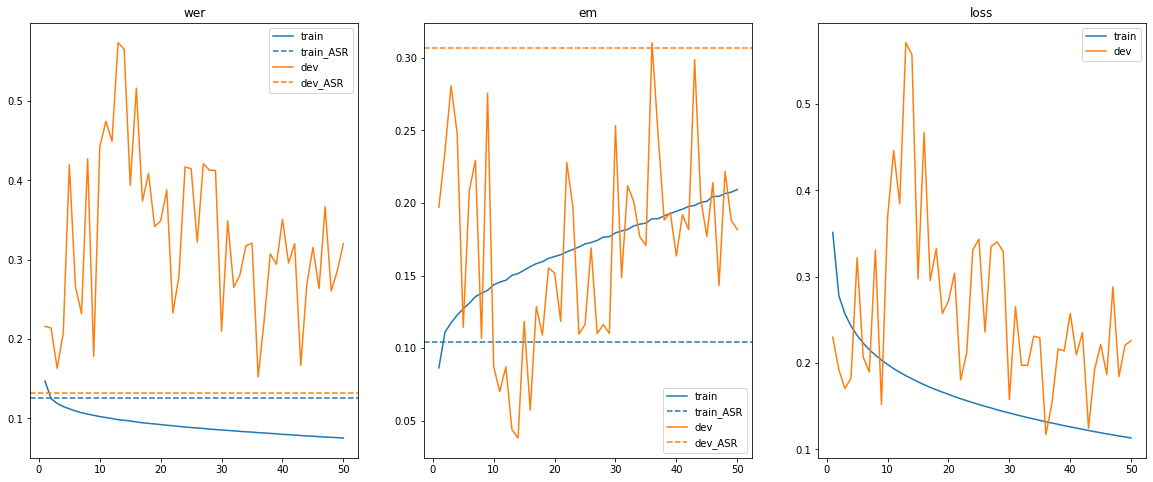

In [17]:
plot_graphs(orig_metrics_df, gt_df=asr_evaluators['Clean'].metrics_df, fig_size=(20,8))

## Model REC-ACE (on Other data)

#### Training

In [18]:
assert debug==False, "You are in debug mode, please change to False"

rec_ace_other_model = RecACEWrapModel(t5_type=t5_type, model_type='rec_ace', bin_size=bin_size, use_pretrained=True).to(DEVICE)
rec_ace_other_optimizer = torch.optim.Adam(rec_ace_other_model.parameters(), lr=1e-4)

rec_ace_other_model, rec_ace_other_metrics_df = training(
    model=rec_ace_other_model,
    n_epochs=50,
    train_data=train_loader_other,
    dev_data=dev_loader_other,
    optimizer=rec_ace_other_optimizer,
    exp_name=f"rec_ace_Other",
    save_model=True)

Experiment name: rec_ace_Other
Training model of type: rec_ace
Confidence vectors are IN USED
Saving model to: ./results\rec_ace_Other/2023-08-24_01-05-43


  0%|          | 0/50 [00:00<?, ?it/s]

Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 1/50
		Loss	|	Train AVG: 0.4981, Dev AVG: 0.3047
		Metrics	|	Train: wer=0.2371, em=0.04645 ; Dev: wer=0.2599, em=0.1399


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 2/50
		Loss	|	Train AVG: 0.4196, Dev AVG: 0.2812
		Metrics	|	Train: wer=0.2132, em=0.05786 ; Dev: wer=0.248, em=0.1449


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 3/50
		Loss	|	Train AVG: 0.3928, Dev AVG: 0.2701
		Metrics	|	Train: wer=0.2055, em=0.061 ; Dev: wer=0.2419, em=0.1484


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 4/50
		Loss	|	Train AVG: 0.3753, Dev AVG: 0.2633
		Metrics	|	Train: wer=0.2003, em=0.06358 ; Dev: wer=0.2385, em=0.1524


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 5/50
		Loss	|	Train AVG: 0.3623, Dev AVG: 0.2558
		Metrics	|	Train: wer=0.1966, em=0.06543 ; Dev: wer=0.2344, em=0.1545


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 6/50
		Loss	|	Train AVG: 0.3517, Dev AVG: 0.2523
		Metrics	|	Train: wer=0.1936, em=0.06727 ; Dev: wer=0.2323, em=0.1553


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 7/50
		Loss	|	Train AVG: 0.3426, Dev AVG: 0.2483
		Metrics	|	Train: wer=0.1909, em=0.06873 ; Dev: wer=0.2309, em=0.1567


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 8/50
		Loss	|	Train AVG: 0.3349, Dev AVG: 0.2453
		Metrics	|	Train: wer=0.1886, em=0.07068 ; Dev: wer=0.2294, em=0.1563


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 9/50
		Loss	|	Train AVG: 0.328, Dev AVG: 0.2431
		Metrics	|	Train: wer=0.1865, em=0.07156 ; Dev: wer=0.2278, em=0.1588


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 10/50
		Loss	|	Train AVG: 0.322, Dev AVG: 0.2393
		Metrics	|	Train: wer=0.1848, em=0.07248 ; Dev: wer=0.2269, em=0.1599


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 11/50
		Loss	|	Train AVG: 0.3163, Dev AVG: 0.2379
		Metrics	|	Train: wer=0.183, em=0.074 ; Dev: wer=0.2264, em=0.1606


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 12/50
		Loss	|	Train AVG: 0.3114, Dev AVG: 0.2353
		Metrics	|	Train: wer=0.1816, em=0.07463 ; Dev: wer=0.2252, em=0.1609


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 13/50
		Loss	|	Train AVG: 0.3067, Dev AVG: 0.2346
		Metrics	|	Train: wer=0.1801, em=0.07547 ; Dev: wer=0.2246, em=0.1627


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 14/50
		Loss	|	Train AVG: 0.3022, Dev AVG: 0.2345
		Metrics	|	Train: wer=0.1788, em=0.07638 ; Dev: wer=0.2238, em=0.1648


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 15/50
		Loss	|	Train AVG: 0.2982, Dev AVG: 0.2312
		Metrics	|	Train: wer=0.1774, em=0.07735 ; Dev: wer=0.223, em=0.1631


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 16/50
		Loss	|	Train AVG: 0.2943, Dev AVG: 0.2317
		Metrics	|	Train: wer=0.1763, em=0.07815 ; Dev: wer=0.2228, em=0.1641


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 17/50
		Loss	|	Train AVG: 0.2906, Dev AVG: 0.2297
		Metrics	|	Train: wer=0.175, em=0.07921 ; Dev: wer=0.2211, em=0.167


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 18/50
		Loss	|	Train AVG: 0.2871, Dev AVG: 0.2301
		Metrics	|	Train: wer=0.174, em=0.08006 ; Dev: wer=0.2216, em=0.1648


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 19/50
		Loss	|	Train AVG: 0.2839, Dev AVG: 0.2288
		Metrics	|	Train: wer=0.1729, em=0.08066 ; Dev: wer=0.2204, em=0.167


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 20/50
		Loss	|	Train AVG: 0.2807, Dev AVG: 0.2283
		Metrics	|	Train: wer=0.172, em=0.08148 ; Dev: wer=0.2197, em=0.1674


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 21/50
		Loss	|	Train AVG: 0.2777, Dev AVG: 0.2275
		Metrics	|	Train: wer=0.171, em=0.08178 ; Dev: wer=0.2198, em=0.167


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 22/50
		Loss	|	Train AVG: 0.2746, Dev AVG: 0.2276
		Metrics	|	Train: wer=0.17, em=0.08263 ; Dev: wer=0.2196, em=0.1684


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 23/50
		Loss	|	Train AVG: 0.2719, Dev AVG: 0.2259
		Metrics	|	Train: wer=0.1692, em=0.08351 ; Dev: wer=0.2187, em=0.1695


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 24/50
		Loss	|	Train AVG: 0.2692, Dev AVG: 0.2249
		Metrics	|	Train: wer=0.1682, em=0.08397 ; Dev: wer=0.2184, em=0.1703


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 25/50
		Loss	|	Train AVG: 0.2666, Dev AVG: 0.2254
		Metrics	|	Train: wer=0.1673, em=0.08512 ; Dev: wer=0.2179, em=0.1699


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 26/50
		Loss	|	Train AVG: 0.2642, Dev AVG: 0.2248
		Metrics	|	Train: wer=0.1665, em=0.08535 ; Dev: wer=0.2182, em=0.1713


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 27/50
		Loss	|	Train AVG: 0.2619, Dev AVG: 0.2244
		Metrics	|	Train: wer=0.1658, em=0.08629 ; Dev: wer=0.219, em=0.1699


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 28/50
		Loss	|	Train AVG: 0.2592, Dev AVG: 0.2242
		Metrics	|	Train: wer=0.1647, em=0.08665 ; Dev: wer=0.2176, em=0.1735


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 29/50
		Loss	|	Train AVG: 0.257, Dev AVG: 0.2241
		Metrics	|	Train: wer=0.1642, em=0.08729 ; Dev: wer=0.2178, em=0.1716


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 30/50
		Loss	|	Train AVG: 0.2549, Dev AVG: 0.224
		Metrics	|	Train: wer=0.1634, em=0.08745 ; Dev: wer=0.218, em=0.1709


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 31/50
		Loss	|	Train AVG: 0.2528, Dev AVG: 0.2234
		Metrics	|	Train: wer=0.1627, em=0.08878 ; Dev: wer=0.2176, em=0.1731


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 32/50
		Loss	|	Train AVG: 0.2506, Dev AVG: 0.2241
		Metrics	|	Train: wer=0.1621, em=0.08972 ; Dev: wer=0.2175, em=0.1734


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 33/50
		Loss	|	Train AVG: 0.2485, Dev AVG: 0.224
		Metrics	|	Train: wer=0.1612, em=0.09088 ; Dev: wer=0.2173, em=0.1734


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 34/50
		Loss	|	Train AVG: 0.2468, Dev AVG: 0.2227
		Metrics	|	Train: wer=0.1605, em=0.09044 ; Dev: wer=0.2174, em=0.172


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 35/50
		Loss	|	Train AVG: 0.2448, Dev AVG: 0.2223
		Metrics	|	Train: wer=0.1599, em=0.09074 ; Dev: wer=0.217, em=0.1745


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 36/50
		Loss	|	Train AVG: 0.2427, Dev AVG: 0.2238
		Metrics	|	Train: wer=0.1591, em=0.09263 ; Dev: wer=0.2157, em=0.1755


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 37/50
		Loss	|	Train AVG: 0.2408, Dev AVG: 0.2226
		Metrics	|	Train: wer=0.1585, em=0.09266 ; Dev: wer=0.2154, em=0.1723


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 38/50
		Loss	|	Train AVG: 0.2392, Dev AVG: 0.2225
		Metrics	|	Train: wer=0.1579, em=0.09325 ; Dev: wer=0.2153, em=0.1734


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 39/50
		Loss	|	Train AVG: 0.2375, Dev AVG: 0.2231
		Metrics	|	Train: wer=0.1573, em=0.09421 ; Dev: wer=0.2158, em=0.1752


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 40/50
		Loss	|	Train AVG: 0.2357, Dev AVG: 0.2216
		Metrics	|	Train: wer=0.1566, em=0.09476 ; Dev: wer=0.2163, em=0.172


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 41/50
		Loss	|	Train AVG: 0.2339, Dev AVG: 0.222
		Metrics	|	Train: wer=0.156, em=0.09459 ; Dev: wer=0.2149, em=0.1738


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 42/50
		Loss	|	Train AVG: 0.2325, Dev AVG: 0.2216
		Metrics	|	Train: wer=0.1556, em=0.09583 ; Dev: wer=0.2148, em=0.1731


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 43/50
		Loss	|	Train AVG: 0.2308, Dev AVG: 0.2211
		Metrics	|	Train: wer=0.1548, em=0.09653 ; Dev: wer=0.2152, em=0.1738


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 44/50
		Loss	|	Train AVG: 0.2292, Dev AVG: 0.2223
		Metrics	|	Train: wer=0.1542, em=0.09621 ; Dev: wer=0.2147, em=0.1777


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 45/50
		Loss	|	Train AVG: 0.2276, Dev AVG: 0.2215
		Metrics	|	Train: wer=0.1536, em=0.09763 ; Dev: wer=0.2148, em=0.1752


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 46/50
		Loss	|	Train AVG: 0.2261, Dev AVG: 0.2207
		Metrics	|	Train: wer=0.1531, em=0.09831 ; Dev: wer=0.2149, em=0.1766


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 47/50
		Loss	|	Train AVG: 0.2245, Dev AVG: 0.2218
		Metrics	|	Train: wer=0.1525, em=0.09862 ; Dev: wer=0.2149, em=0.1759


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 48/50
		Loss	|	Train AVG: 0.223, Dev AVG: 0.2217
		Metrics	|	Train: wer=0.1521, em=0.09883 ; Dev: wer=0.2143, em=0.1777


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 49/50
		Loss	|	Train AVG: 0.2216, Dev AVG: 0.2216
		Metrics	|	Train: wer=0.1513, em=0.09937 ; Dev: wer=0.214, em=0.1787


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 50/50
		Loss	|	Train AVG: 0.2202, Dev AVG: 0.2224
		Metrics	|	Train: wer=0.1509, em=0.09987 ; Dev: wer=0.2152, em=0.1745

Training finished!



#### Analysis

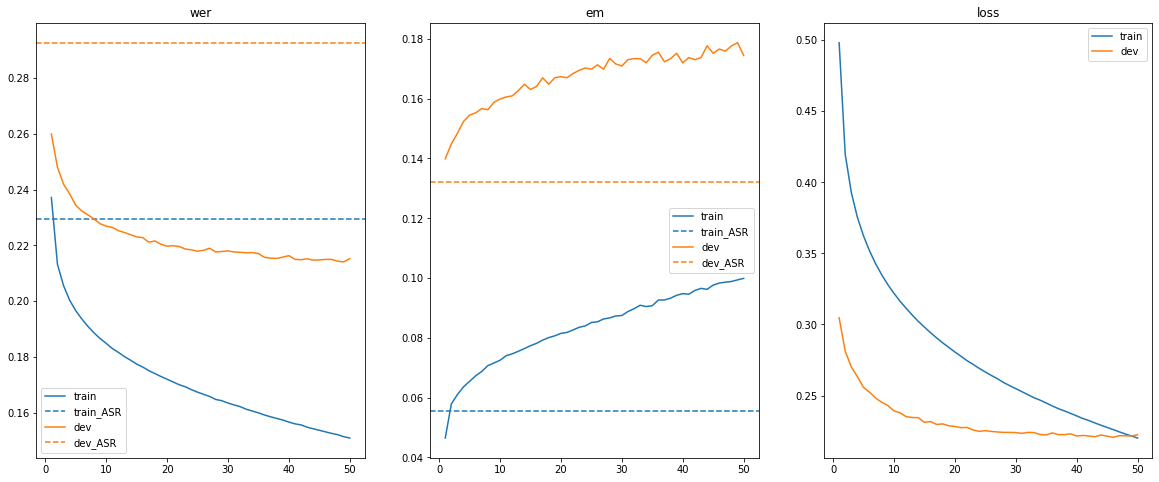

In [19]:
plot_graphs(rec_ace_other_metrics_df, gt_df=asr_evaluators['Other'].metrics_df, fig_size=(20,8))

## Model Original T5 (on Other data)

#### Training

In [20]:
assert debug==False, "You are in debug mode, please change to False"

orig_other_model = RecACEWrapModel(t5_type=t5_type, model_type='original', bin_size=bin_size, use_pretrained=True).to(DEVICE)
orig_other_optimizer = torch.optim.Adam(orig_other_model.parameters(), lr=1e-4)

orig_other_model, orig_other_metrics_df = training(
    model=orig_other_model,
    n_epochs=50,
    train_data=train_loader_other,
    dev_data=dev_loader_other,
    optimizer=orig_other_optimizer,
    exp_name=f"original_f5_Other",
    save_model=True)

Experiment name: original_f5_Other
Training model of type: original
Confidence vectors are NOT IN USED
Saving model to: ./results\original_f5_Other/2023-08-24_17-27-55


  0%|          | 0/50 [00:00<?, ?it/s]

Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 1/50
		Loss	|	Train AVG: 0.5048, Dev AVG: 0.3126
		Metrics	|	Train: wer=0.2392, em=0.04577 ; Dev: wer=0.2666, em=0.122


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 2/50
		Loss	|	Train AVG: 0.4253, Dev AVG: 0.2994
		Metrics	|	Train: wer=0.2146, em=0.05713 ; Dev: wer=0.255, em=0.1456


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 3/50
		Loss	|	Train AVG: 0.4002, Dev AVG: 0.275
		Metrics	|	Train: wer=0.2072, em=0.0596 ; Dev: wer=0.2446, em=0.1492


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 4/50
		Loss	|	Train AVG: 0.3834, Dev AVG: 0.2788
		Metrics	|	Train: wer=0.2023, em=0.06203 ; Dev: wer=0.2517, em=0.1482


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 5/50
		Loss	|	Train AVG: 0.37, Dev AVG: 0.2707
		Metrics	|	Train: wer=0.1987, em=0.0639 ; Dev: wer=0.247, em=0.1521


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 6/50
		Loss	|	Train AVG: 0.3595, Dev AVG: 0.2688
		Metrics	|	Train: wer=0.1956, em=0.06584 ; Dev: wer=0.2472, em=0.1535


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 7/50
		Loss	|	Train AVG: 0.3503, Dev AVG: 0.2552
		Metrics	|	Train: wer=0.1931, em=0.06692 ; Dev: wer=0.2366, em=0.1509


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 8/50
		Loss	|	Train AVG: 0.3427, Dev AVG: 0.2651
		Metrics	|	Train: wer=0.1908, em=0.06787 ; Dev: wer=0.2469, em=0.156


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 9/50
		Loss	|	Train AVG: 0.3359, Dev AVG: 0.2534
		Metrics	|	Train: wer=0.189, em=0.06873 ; Dev: wer=0.2367, em=0.1581


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 10/50
		Loss	|	Train AVG: 0.3296, Dev AVG: 0.2463
		Metrics	|	Train: wer=0.1871, em=0.07004 ; Dev: wer=0.23, em=0.1599


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 11/50
		Loss	|	Train AVG: 0.324, Dev AVG: 0.2463
		Metrics	|	Train: wer=0.1856, em=0.07057 ; Dev: wer=0.2306, em=0.1553


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 12/50
		Loss	|	Train AVG: 0.319, Dev AVG: 0.2575
		Metrics	|	Train: wer=0.1839, em=0.0718 ; Dev: wer=0.2439, em=0.1553


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 13/50
		Loss	|	Train AVG: 0.3142, Dev AVG: 0.2412
		Metrics	|	Train: wer=0.1825, em=0.07286 ; Dev: wer=0.2291, em=0.1592


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 14/50
		Loss	|	Train AVG: 0.31, Dev AVG: 0.2502
		Metrics	|	Train: wer=0.1816, em=0.07286 ; Dev: wer=0.2401, em=0.1556


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 15/50
		Loss	|	Train AVG: 0.3057, Dev AVG: 0.2389
		Metrics	|	Train: wer=0.1799, em=0.07468 ; Dev: wer=0.2272, em=0.1609


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 16/50
		Loss	|	Train AVG: 0.3018, Dev AVG: 0.2376
		Metrics	|	Train: wer=0.1788, em=0.07521 ; Dev: wer=0.2283, em=0.1613


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 17/50
		Loss	|	Train AVG: 0.2981, Dev AVG: 0.2375
		Metrics	|	Train: wer=0.1778, em=0.0756 ; Dev: wer=0.2279, em=0.1602


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 18/50
		Loss	|	Train AVG: 0.2946, Dev AVG: 0.2385
		Metrics	|	Train: wer=0.1767, em=0.07542 ; Dev: wer=0.2288, em=0.1599


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 19/50
		Loss	|	Train AVG: 0.2911, Dev AVG: 0.2388
		Metrics	|	Train: wer=0.1755, em=0.0766 ; Dev: wer=0.2255, em=0.162


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 20/50
		Loss	|	Train AVG: 0.2881, Dev AVG: 0.2341
		Metrics	|	Train: wer=0.1746, em=0.07673 ; Dev: wer=0.2248, em=0.1592


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 21/50
		Loss	|	Train AVG: 0.285, Dev AVG: 0.2346
		Metrics	|	Train: wer=0.1736, em=0.07842 ; Dev: wer=0.2255, em=0.1599


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 22/50
		Loss	|	Train AVG: 0.282, Dev AVG: 0.2322
		Metrics	|	Train: wer=0.1727, em=0.07882 ; Dev: wer=0.2244, em=0.1613


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 23/50
		Loss	|	Train AVG: 0.2793, Dev AVG: 0.2329
		Metrics	|	Train: wer=0.1718, em=0.07963 ; Dev: wer=0.2228, em=0.1634


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 24/50
		Loss	|	Train AVG: 0.2765, Dev AVG: 0.2295
		Metrics	|	Train: wer=0.171, em=0.08055 ; Dev: wer=0.2224, em=0.1638


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 25/50
		Loss	|	Train AVG: 0.2741, Dev AVG: 0.2297
		Metrics	|	Train: wer=0.1701, em=0.08084 ; Dev: wer=0.2207, em=0.1652


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 26/50
		Loss	|	Train AVG: 0.2714, Dev AVG: 0.2299
		Metrics	|	Train: wer=0.1692, em=0.0816 ; Dev: wer=0.2209, em=0.168


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 27/50
		Loss	|	Train AVG: 0.269, Dev AVG: 0.2293
		Metrics	|	Train: wer=0.1685, em=0.08218 ; Dev: wer=0.2209, em=0.1684


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 28/50
		Loss	|	Train AVG: 0.2666, Dev AVG: 0.2299
		Metrics	|	Train: wer=0.1676, em=0.0821 ; Dev: wer=0.2203, em=0.1681


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 29/50
		Loss	|	Train AVG: 0.2644, Dev AVG: 0.2285
		Metrics	|	Train: wer=0.1669, em=0.08285 ; Dev: wer=0.2203, em=0.1677


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 30/50
		Loss	|	Train AVG: 0.2621, Dev AVG: 0.2285
		Metrics	|	Train: wer=0.1663, em=0.08386 ; Dev: wer=0.2196, em=0.1681


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 31/50
		Loss	|	Train AVG: 0.2599, Dev AVG: 0.2282
		Metrics	|	Train: wer=0.1654, em=0.08462 ; Dev: wer=0.2201, em=0.1684


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 32/50
		Loss	|	Train AVG: 0.2579, Dev AVG: 0.2274
		Metrics	|	Train: wer=0.165, em=0.08457 ; Dev: wer=0.2195, em=0.1688


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 33/50
		Loss	|	Train AVG: 0.2559, Dev AVG: 0.2286
		Metrics	|	Train: wer=0.1642, em=0.08548 ; Dev: wer=0.219, em=0.1677


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 34/50
		Loss	|	Train AVG: 0.254, Dev AVG: 0.2279
		Metrics	|	Train: wer=0.1635, em=0.08649 ; Dev: wer=0.2197, em=0.172


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 35/50
		Loss	|	Train AVG: 0.2518, Dev AVG: 0.2281
		Metrics	|	Train: wer=0.1629, em=0.08623 ; Dev: wer=0.2193, em=0.1717


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 36/50
		Loss	|	Train AVG: 0.2501, Dev AVG: 0.2282
		Metrics	|	Train: wer=0.1622, em=0.08679 ; Dev: wer=0.2185, em=0.1692


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 37/50
		Loss	|	Train AVG: 0.2481, Dev AVG: 0.2274
		Metrics	|	Train: wer=0.1615, em=0.08766 ; Dev: wer=0.2194, em=0.1688


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 38/50
		Loss	|	Train AVG: 0.2463, Dev AVG: 0.2283
		Metrics	|	Train: wer=0.1611, em=0.08784 ; Dev: wer=0.2193, em=0.1702


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 39/50
		Loss	|	Train AVG: 0.2444, Dev AVG: 0.2278
		Metrics	|	Train: wer=0.1602, em=0.08879 ; Dev: wer=0.2196, em=0.1681


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 40/50
		Loss	|	Train AVG: 0.2429, Dev AVG: 0.2286
		Metrics	|	Train: wer=0.1597, em=0.08908 ; Dev: wer=0.2193, em=0.171


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 41/50
		Loss	|	Train AVG: 0.2412, Dev AVG: 0.2278
		Metrics	|	Train: wer=0.1591, em=0.0891 ; Dev: wer=0.2189, em=0.1727


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 42/50
		Loss	|	Train AVG: 0.2395, Dev AVG: 0.2269
		Metrics	|	Train: wer=0.1585, em=0.08984 ; Dev: wer=0.2189, em=0.1709


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 43/50
		Loss	|	Train AVG: 0.2378, Dev AVG: 0.2272
		Metrics	|	Train: wer=0.158, em=0.09014 ; Dev: wer=0.2179, em=0.1699


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 44/50
		Loss	|	Train AVG: 0.236, Dev AVG: 0.2269
		Metrics	|	Train: wer=0.1571, em=0.09098 ; Dev: wer=0.2181, em=0.1713


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 45/50
		Loss	|	Train AVG: 0.2346, Dev AVG: 0.228
		Metrics	|	Train: wer=0.1567, em=0.09065 ; Dev: wer=0.2187, em=0.1699


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 46/50
		Loss	|	Train AVG: 0.233, Dev AVG: 0.2281
		Metrics	|	Train: wer=0.1562, em=0.09233 ; Dev: wer=0.2178, em=0.1706


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 47/50
		Loss	|	Train AVG: 0.2315, Dev AVG: 0.2273
		Metrics	|	Train: wer=0.1556, em=0.0927 ; Dev: wer=0.2172, em=0.1735


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 48/50
		Loss	|	Train AVG: 0.2301, Dev AVG: 0.2282
		Metrics	|	Train: wer=0.1552, em=0.09321 ; Dev: wer=0.2169, em=0.172


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 49/50
		Loss	|	Train AVG: 0.2285, Dev AVG: 0.2277
		Metrics	|	Train: wer=0.1545, em=0.09378 ; Dev: wer=0.218, em=0.1727


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Dev:   0%|          | 0/44 [00:00<?, ?it/s]

	Done Epoch: 50/50
		Loss	|	Train AVG: 0.2271, Dev AVG: 0.2277
		Metrics	|	Train: wer=0.1539, em=0.09417 ; Dev: wer=0.218, em=0.1709

Training finished!



#### Analysis

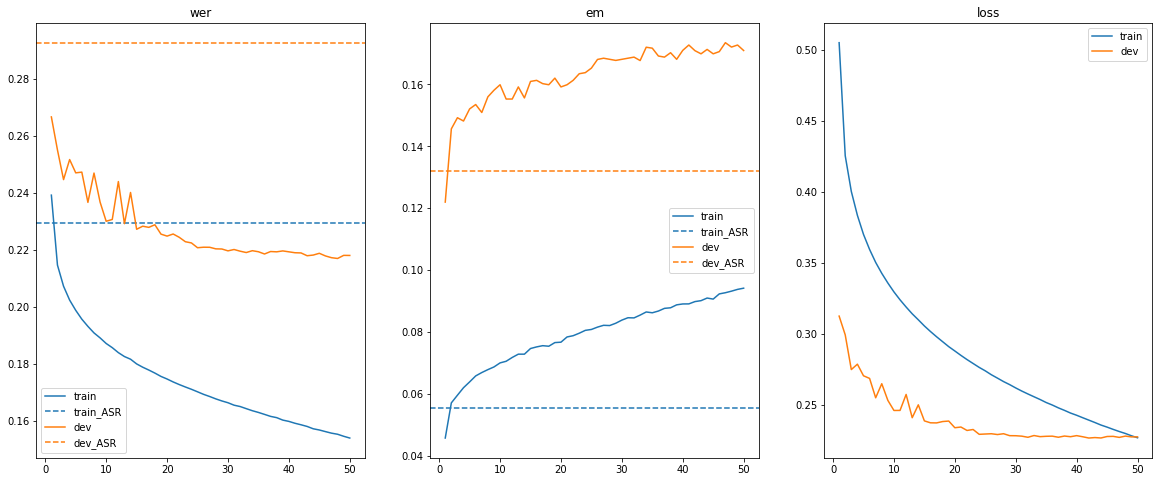

In [21]:
plot_graphs(orig_other_metrics_df, gt_df=asr_evaluators['Other'].metrics_df, fig_size=(20,8))